In [1]:
import os
os.chdir("../../../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, product
from src.tourism.ts_utils import check_and_modify_date
from src.tourism.mtsmodel import *
from src.tourism.utsmodel import *
from src.tourism.data import *

In [2]:
mod_s = SARIMAXPipeline(country="samoa",
                        y_var="total",
                        exog_var=["covid", "stringency_index"],
                        transform_method="scaledlogit",
                        training_ratio=0.9)
mod_s.read_and_merge()
mod_s.transform()
mod_s.stepwise_search()
mod_s.manual_search()

training size : 217, testing size : 25


In [3]:
mod = RatioPipe(country="samoa",
                y_var="total",
                exog_var=["covid", "stringency_index"],
                training_ratio=0.9)
mod.read_and_merge()
mod.transform()
mod.fit("ratio ~ covid*stringency_index + C(quarter) + samoa_travel")

In [4]:
X_future = mod.covid_raw.merge(mod.trends_raw, how="right")[["date", "samoa travel", "covid", "stringency_index"]]
X_future["quarter"] = X_future["date"].dt.quarter
X_future.columns = [col.replace(" ", "_") for col in X_future.columns]

In [5]:
X_future = X_future[X_future.date >= "2019-01-01"].fillna(0).reset_index(drop=True)

In [6]:
mod_prediction = mod.res.get_prediction(X_future).summary_frame()
for idx in mod.model_data.index:
    mod_prediction.iloc[idx, :] = mod_prediction.iloc[idx, :] * mod.model_data["seats_arrivals_intl"][idx]
    
mod_prediction["date"] = X_future["date"]
mod_prediction = mod_prediction[mod_prediction.date < "2023-11-01"]

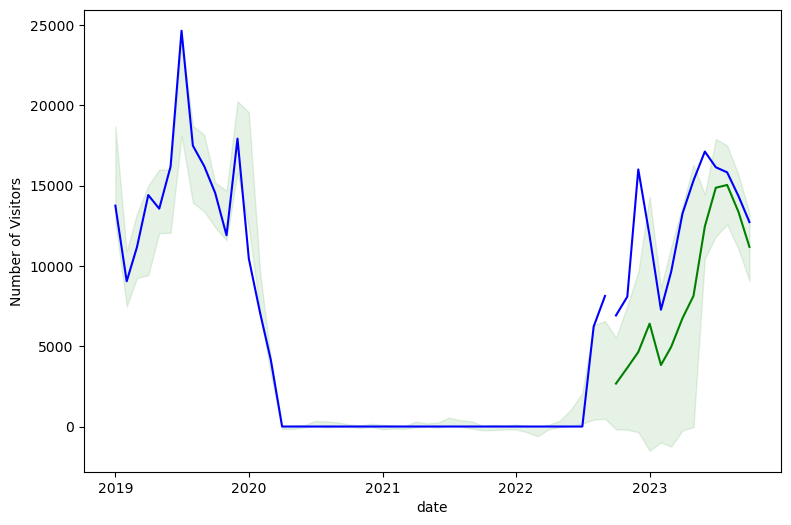

In [9]:
real = [
    6917, 8085, 16009, 11868, 7273, 9643, 13271, 15321, 17122, 16145, 15829,
    14351, 12729
]

real_df = pd.DataFrame({
    "date":
    pd.date_range(start="2022-10-01", periods=len(real), freq="MS"),
    "actual_visitor":
    real
})
real_df["predict"] = mod_prediction["mean"][45:].tolist()

fig, ax = plt.subplots(figsize=(9, 6))

sns.lineplot(data=real_df, x="date", y="actual_visitor", ax=ax, color="blue")
sns.lineplot(data=mod.model_data, x="date", y="total", ax=ax, color="blue")
sns.lineplot(data=real_df, x="date", y="predict", ax=ax, color="green")
plt.fill_between(x=mod_prediction.date,
                 y1=mod_prediction.mean_ci_lower,
                 y2=mod_prediction.mean_ci_upper,
                 alpha=0.1,
                 color="green")
ax.set_ylabel("Number of Visitors")
plt.show()

In [10]:
from src.tourism.ts_eval import *

calculate_evaluation(real_df["actual_visitor"], real_df["predict"])

{'MSE': 27076663.401289623,
 'RMSE': 5203.524132863191,
 'MAE': 4353.219048163771,
 'SMAPE': 50.09592507891855}